In [14]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
# Load the cleaned DataFrame
# For ARM, we need unlabeled transaction data, so let's simulate job data transactions
# We assume each row is a 'transaction' representing the presence of various job features.
df_jobs_cleaned = pd.read_csv("df_jobs_cleaned.csv")

In [16]:
# Create a sample of binary transaction data by selecting relevant features
# For simplicity, let's consider salary ranges, vacancy duration, and disability mention as categorical
transaction_columns = ['SalaryMin', 'SalaryMax', 'VacancyDuration', 'DisabilityMention']

In [17]:
# Convert the numerical data to categorical bins
df_transactions = df_jobs_cleaned[transaction_columns].copy()
df_transactions['SalaryMin'] = pd.cut(df_transactions['SalaryMin'], bins=3, labels=['Low', 'Medium', 'High'])
df_transactions['SalaryMax'] = pd.cut(df_transactions['SalaryMax'], bins=3, labels=['Low', 'Medium', 'High'])
df_transactions['VacancyDuration'] = pd.cut(df_transactions['VacancyDuration'], bins=3, labels=['Short', 'Medium', 'Long'])
df_transactions['DisabilityMention'] = df_transactions['DisabilityMention'].map({True: 'Yes', False: 'No'})

In [18]:
# Convert the categorical features to a one-hot encoded DataFrame
df_encoded = pd.get_dummies(df_transactions)

In [19]:
# Save the prepared transaction data for ARM
df_encoded.to_csv("df_jobs_transactions.csv", index=False)
print("Transaction data for ARM saved as df_jobs_transactions.csv")

Transaction data for ARM saved as df_jobs_transactions.csv


In [20]:
# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
print("Top 15 Frequent Itemsets by Support:")
print(frequent_itemsets.head(15))

Top 15 Frequent Itemsets by Support:
     support                                           itemsets
7   0.988095                             (DisabilityMention_No)
0   0.821429                                    (SalaryMin_Low)
12  0.809524              (DisabilityMention_No, SalaryMin_Low)
6   0.666667                             (VacancyDuration_Long)
21  0.654762       (DisabilityMention_No, VacancyDuration_Long)
11  0.630952              (VacancyDuration_Long, SalaryMin_Low)
28  0.619048  (DisabilityMention_No, VacancyDuration_Long, S...
3   0.500000                                 (SalaryMax_Medium)
18  0.488095           (DisabilityMention_No, SalaryMax_Medium)
2   0.452381                                    (SalaryMax_Low)
16  0.452381              (DisabilityMention_No, SalaryMax_Low)
24  0.428571  (DisabilityMention_No, SalaryMax_Low, SalaryMi...
17  0.428571           (SalaryMax_Medium, VacancyDuration_Long)
8   0.428571                     (SalaryMax_Low, SalaryMin_Low)
31 

In [21]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

In [22]:
# Sort and display the top 15 rules by support, confidence, and lift
top_15_support = rules.sort_values(by='support', ascending=False).head(15)
top_15_confidence = rules.sort_values(by='confidence', ascending=False).head(15)
top_15_lift = rules.sort_values(by='lift', ascending=False).head(15)

In [23]:
print("Top 15 Rules by Support:")
print(top_15_support)
print("\nTop 15 Rules by Confidence:")
print(top_15_confidence)
print("\nTop 15 Rules by Lift:")
print(top_15_lift)

Top 15 Rules by Support:
                                     antecedents  \
0                         (DisabilityMention_No)   
1                                (SalaryMin_Low)   
2                         (DisabilityMention_No)   
3                         (VacancyDuration_Long)   
4                         (VacancyDuration_Long)   
5                                (SalaryMin_Low)   
10                        (VacancyDuration_Long)   
11                               (SalaryMin_Low)   
9                         (DisabilityMention_No)   
8          (VacancyDuration_Long, SalaryMin_Low)   
7          (DisabilityMention_No, SalaryMin_Low)   
6   (DisabilityMention_No, VacancyDuration_Long)   
12                            (SalaryMax_Medium)   
13                               (SalaryMax_Low)   
18                               (SalaryMin_Low)   

                                     consequents  antecedent support  \
0                                (SalaryMin_Low)            0.988095  

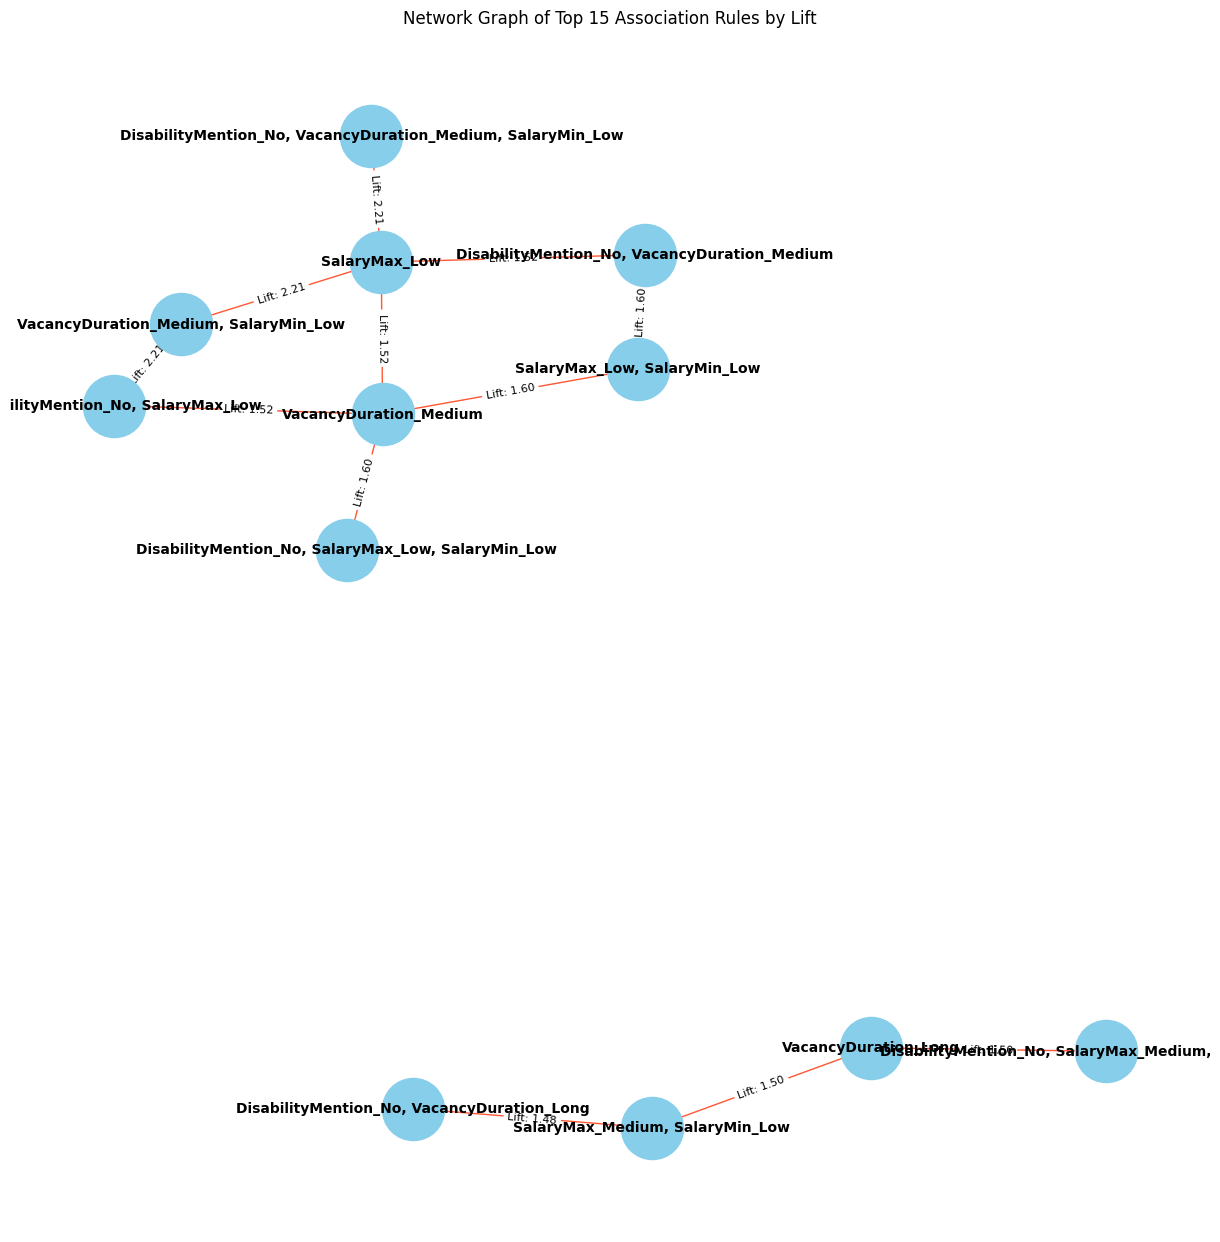

In [24]:
# Visualize the top associations using a network graph
G = nx.Graph()

for _, rule in top_15_lift.iterrows():
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    G.add_edge(antecedents, consequents, weight=rule['lift'])

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_weight='bold', edge_color='#FF5733')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"Lift: {d['weight']:.2f}" for u, v, d in G.edges(data=True)}, font_size=8)
plt.title("Network Graph of Top 15 Association Rules by Lift")
plt.savefig("association_rules_network.png")
plt.show()